# Extracellular Electrophysiology Data

At the Allen Institute for Brain Science we carry out in vivo extracellular electrophysiology (ecephys) experiments  in awake animals using high-density Neuropixels probes. The data from these experiments are organized into *sessions*, where each session is a distinct continuous recording period. During a session we collect:

- spike times and characteristics (such as mean waveforms) from up to 6 neuropixels probes
- local field potentials
- behavioral data, such as running speed and eye position
- visual stimuli which were presented during the session
- cell-type specific optogenetic stimuli that were applied during the session

The AllenSDK contains code for accessing across-session (project-level) metadata as well as code for accessing detailed within-session data. The standard workflow is to use project-level tools, such as `EcephysProjectCache` to identify and access sessions of interest, then delve into those sessions' data using `EcephysSession`.


Project-level
------------------
The `EcephysProjectCache` class in `allensdk.brain_observatory.ecephys.ecephys_project_cache` accesses and stores data pertaining to many sessions. You can use this class to run queries that span all collected sessions and to download data for individual sessions.
* <a href='#Obtaining-an-EcephysProjectCache'>Obtaining an `EcephysProjectCache`</a>
* <a href='#Querying-across-sessions'>Querying sessions</a>
* <a href='#Querying-across-probes'>Querying probes</a>
* <a href='#Querying-across-units'>Querying units</a>
* <a href='#Surveying-metadata'>Surveying metadata</a>


Session-level
-------------------
The `EcephysSession` class in `allensdk.brain_observatory.ecephys.ecephys_session` provides an interface to all of the data for a single session, aligned to a common clock. This notebook will show you how to use the `EcephysSession` class to extract these data.
* <a href='#Obtaining-an-EcephysSession'>Obtaining an `EcephysSession`</a>
* <a href='#Stimulus-presentations'>Stimulus information</a>
* <a href='#Spike-data'>Spike data</a>
* <a href='#Spike-histograms'>Spike histograms</a>
* <a href='#Running-speed'>Running speed</a>
* <a href='#Optogenetic-stimulation'>Optogenetic stimulation</a>
* <a href='#Local-field-potential'>Local Field Potential</a>
* <a href='#Current-source-density'>Current source density</a>
* <a href='#Waveforms'>Unitwise mean waveforms</a>
* <a href='#Suggested-excercises'>Suggested excercises</a>

In [1]:
# first we need a bit of import boilerplate
import os

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import (
    EcephysSession, 
    removed_unused_stimulus_presentation_columns
)
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

### Obtaining an `EcephysProjectCache`

In order to create an `EcephysProjectCache` object, you need to specify two things:
1. A remote source for the object to fetch data from. We will instantiate our cache using `EcephysProjectCache.from_warehouse()` to point the cache at the Allen Institute's public web API.
2. A path to a manifest json, which designates filesystem locations for downloaded data. The cache will try to read data from these locations before going to download those data from its remote source, preventing repeated downloads.

In [2]:
manifest_path = os.path.join("example_ecephys_project_cache", "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

### Querying across sessions

Using your `EcephysProjectCache`, you can download a table listing metadata for all sessions.

In [3]:
cache.get_session_table().head()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"


### Querying across probes

... or for all probes

In [4]:
cache.get_probes().head()

,ecephys_session_id,lfp_sampling_rate,name,phase,sampling_rate,has_lfp_data,unit_count,channel_count,ecephys_structure_acronyms
id,,,,,,,,,
729445648,719161530,1249.998642,probeA,3a,29999.967418,True,87,374,"[APN, LP, MB, DG, CA1, VISam, nan]"
729445650,719161530,1249.996620,probeB,3a,29999.918880,True,202,368,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan]"
729445652,719161530,1249.999897,probeC,3a,29999.997521,True,207,373,"[APN, NOT, MB, DG, SUB, VISp, nan]"
729445654,719161530,1249.996707,probeD,3a,29999.920963,True,93,358,"[grey, VL, CA3, CA2, CA1, VISl, nan]"
729445656,719161530,1249.999979,probeE,3a,29999.999500,True,138,370,"[PO, VPM, TH, LP, LGd, CA3, DG, CA1, VISal, nan]"


### Querying across channels

... or across channels.

In [5]:
cache.get_channels().head()

,ecephys_probe_id,local_index,probe_horizontal_position,probe_vertical_position,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,ecephys_structure_id,ecephys_structure_acronym,ecephys_session_id,lfp_sampling_rate,phase,sampling_rate,has_lfp_data,unit_count
id,,,,,,,,,,,,,,,
849705558,792645504,1,11,20,8165,3314,6862,215.0,APN,779839471,1250.001479,3a,30000.035489,True,0
849705560,792645504,2,59,40,8162,3307,6866,215.0,APN,779839471,1250.001479,3a,30000.035489,True,0
849705562,792645504,3,27,40,8160,3301,6871,215.0,APN,779839471,1250.001479,3a,30000.035489,True,0
849705564,792645504,4,43,60,8157,3295,6875,215.0,APN,779839471,1250.001479,3a,30000.035489,True,0
849705566,792645504,5,11,60,8155,3288,6879,215.0,APN,779839471,1250.001479,3a,30000.035489,True,0


### Querying across units

... as well as for sorted units.

In [6]:
units = cache.get_units()
units.head()

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cumulative_drift,d_prime,waveform_duration,ecephys_channel_id,firing_rate,waveform_halfwidth,isi_violations,isolation_distance,L_ratio,max_drift,nn_hit_rate,nn_miss_rate,presence_ratio,waveform_recovery_slope,waveform_repolarization_slope,silhouette_score,snr,waveform_spread,waveform_velocity_above,waveform_velocity_below,ecephys_probe_id,local_index,probe_horizontal_position,probe_vertical_position,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,ecephys_structure_id,ecephys_structure_acronym,ecephys_session_id,lfp_sampling_rate,name,phase,sampling_rate,has_lfp_data,date_of_acquisition,published_at,specimen_id,session_type,age_in_days,sex,genotype
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
915956282,0.611816,164.878740,0.072728,309.71,3.910873,0.535678,850229419,6.519432,0.164824,0.104910,30.546900,0.013865,27.10,0.898126,0.001599,0.99,-0.087545,0.480915,0.102369,1.911839,30.0,0.000000,NaN,733744647,3,27,40,-1000,-1000,-1000,8.0,grey,732592105,1249.996475,probeB,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956340,0.439372,247.254345,0.000881,160.24,5.519024,0.563149,850229419,9.660554,0.206030,0.006825,59.613182,0.000410,7.79,0.987654,0.000903,0.99,-0.104196,0.704522,0.197458,3.357908,30.0,0.000000,NaN,733744647,3,27,40,-1000,-1000,-1000,8.0,grey,732592105,1249.996475,probeB,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956345,0.500520,251.275830,0.001703,129.36,3.559911,0.521943,850229419,12.698430,0.192295,0.044936,47.805714,0.008281,11.56,0.930000,0.004956,0.99,-0.153127,0.781296,0.138827,3.362198,30.0,0.343384,NaN,733744647,3,27,40,-1000,-1000,-1000,8.0,grey,732592105,1249.996475,probeB,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956349,0.424620,177.115380,0.096378,169.29,2.973959,0.508208,850229419,16.192413,0.192295,0.120715,54.635515,0.010406,14.87,0.874667,0.021636,0.99,-0.086022,0.553393,0.136901,2.684636,40.0,0.206030,NaN,733744647,3,27,40,-1000,-1000,-1000,8.0,grey,732592105,1249.996475,probeB,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956356,0.512847,214.954545,0.054706,263.01,2.936851,0.549414,850229419,2.193113,0.233501,0.430427,18.136302,0.061345,18.37,0.637363,0.000673,0.99,-0.106051,0.632977,0.108867,2.605408,60.0,-0.451304,NaN,733744647,3,27,40,-1000,-1000,-1000,8.0,grey,732592105,1249.996475,probeB,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt


In [7]:
# There are quite a few of these
print(units.shape[0])

40010


### Surveying metadata

You can answer questions like: "what mouse genotypes were used in this dataset?" using your `EcephysProjectCache`.

In [8]:
print(f"stimulus sets: {cache.get_all_session_types()}")
print(f"genotypes: {cache.get_all_full_genotypes()}")
print(f"structures: {cache.get_structure_acronyms()}")

stimulus sets: ['brain_observatory_1.1', 'functional_connectivity']
genotypes: ['Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt', 'Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt', 'wt/wt', 'Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt']
structures: ['APN', 'LP', 'MB', 'DG', 'CA1', 'VISrl', nan, 'TH', 'LGd', 'CA3', 'VIS', 'CA2', 'ProS', 'VISp', 'POL', 'VISpm', 'PPT', 'OP', 'NOT', 'HPF', 'SUB', 'VISam', 'ZI', 'LGv', 'VISal', 'VISl', 'SGN', 'SCig', 'MGm', 'MGv', 'VPM', 'grey', 'Eth', 'VPL', 'IGL', 'PP', 'PIL', 'PO', 'VISmma', 'POST', 'SCop', 'SCsg', 'SCzo', 'SCiw', 'IntG', 'MGd', 'MRN', 'LD', 'VISmmp', 'CP', 'VISli', 'PRE', 'RPF', 'LT', 'PF', 'PoT', 'VL', 'RT']


In order to look up a brain structure acronym, you can use our [online atlas viewer](http://atlas.brain-map.org/atlas?atlas=602630314). The AllenSDK additionally supports programmatic access to structure annotations. For more information, see the [reference space](https://allensdk.readthedocs.io/en/latest/reference_space.html) and [mouse connectivity](https://allensdk.readthedocs.io/en/latest/connectivity.html) documentation.

### Obtaining an `EcephysSession`

We package each session's data into a Neurodata Without Borders 2.0 (NWB) file. Calling `get_session_data` on your `EcephysProjectCache` will download such a file and return an `EcephysSession` object.

`EcephysSession` objects contain methods and properties that access the data within an ecephys NWB file and cache it in memory.

In [9]:
session_id = 756029989 # for example
session = cache.get_session_data(session_id)

This session object has some important metadata, such as the date and time at which the recording session started:

In [10]:
print(f"session {session.ecephys_session_id} was acquired in {session.session_start_time}")

session 756029989 was acquired in 2018-10-26 12:59:18-07:00


We'll now jump in to accessing our session's data. If you ever want a complete documented list of the attributes and methods defined on `EcephysSession`, you can run `help(EcephysSession)` (or in a jupyter notebook: `EcephysSession?`).

### Sorted units

Units are putative neurons, clustered from raw voltage traces using Kilosort 2. Each unit is associated with a single *peak channel* on a single probe, though its spikes might be picked up with some attenuation on multiple nearby channels. Each unit is assigned a unique integer identifier ("unit_id") which can be used to look up its  spike times and its mean waveform.

The units for a session are recorded in an attribute called, fittingly, `units`. This is a `pandas.DataFrame` whose index is the unit id and whose columns contain summary information about the unit, its peak channel, and its associated probe.

In [11]:
session.units.head()

,cumulative_drift,L_ratio,waveform_PT_ratio,waveform_repolarization_slope,amplitude_cutoff,isolation_distance,local_index_unit,cluster_id,peak_channel_id,nn_miss_rate,waveform_velocity_below,waveform_velocity_above,d_prime,waveform_recovery_slope,waveform_amplitude,isi_violations,max_drift,waveform_spread,firing_rate,waveform_duration,presence_ratio,snr,waveform_halfwidth,silhouette_score,nn_hit_rate,c50_dg,area_rf,fano_dg,fano_fl,fano_ns,fano_rf,fano_sg,f1_f0_dg,g_dsi_dg,g_osi_dg,g_osi_sg,azimuth_rf,mod_idx_dg,p_value_rf,pref_sf_sg,pref_tf_dg,run_mod_dg,run_mod_fl,run_mod_ns,run_mod_rf,run_mod_sg,pref_ori_dg,pref_ori_sg,run_pval_dg,run_pval_fl,run_pval_ns,run_pval_rf,run_pval_sg,elevation_rf,pref_image_ns,pref_phase_sg,firing_rate_dg,firing_rate_fl,firing_rate_ns,firing_rate_rf,firing_rate_sg,on_off_ratio_fl,time_to_peak_ns,pref_sf_multi_sg,pref_tf_multi_dg,pref_ori_multi_dg,pref_ori_multi_sg,pref_phase_multi_sg,image_selectivity_ns,pref_image_multi_ns,lifetime_sparseness_dg,lifetime_sparseness_fl,lifetime_sparseness_ns,lifetime_sparseness_rf,lifetime_sparseness_sg,probe_horizontal_position,channel_local_index,probe_id,probe_vertical_position,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
951814884,463.86,0.024771,0.522713,0.673650,0.042404,46.750473,5,6,850126382,0.016202,0.000000,0.000000,3.555518,-0.249885,187.434780,0.181638,45.64,40.0,9.492176,0.151089,0.99,3.342535,0.096147,0.033776,0.727333,NaN,2600.0,2.370440,1.765128,3.983333,1.866667,5.186364,0.244796,0.053998,0.033134,0.023705,61.923,0.612162,0.358,0.04,15.0,-0.154286,-0.005676,-0.228819,-0.212121,-0.310345,180.0,150.0,0.619716,9.763807e-01,0.507405,0.469507,0.447263,-5.000,4929,0.75,17.571944,11.057561,5.845194,8.805963,6.974832,NaN,0.0385,False,False,False,False,False,0.042644,False,0.011829,0.000012,0.062616,0.058606,0.039197,43,4,760640083,60,215.0,APN,8162,3487,6737,probeA,,29999.949611,1249.9979,True
951814876,325.21,0.001785,0.652514,0.518633,0.097286,85.178750,4,5,850126382,0.003756,0.000000,0.000000,4.445414,-0.143762,129.686505,0.004799,40.68,50.0,39.100557,0.315913,0.99,2.589717,0.206030,0.108908,1.000000,NaN,900.0,3.417573,0.704762,0.672690,0.803980,1.003055,0.137709,0.017675,0.015248,0.027334,72.222,0.678473,0.795,0.04,2.0,0.326587,0.231595,0.062157,0.068548,0.068853,315.0,150.0,0.000030,6.157503e-07,0.353566,0.674185,0.472870,45.556,5021,0.00,43.390301,44.709848,36.820288,44.885084,35.195889,NaN,0.1535,False,False,False,False,False,0.214051,False,0.001812,0.000003,0.002366,0.004308,0.002943,43,4,760640083,60,215.0,APN,8162,3487,6737,probeA,,29999.949611,1249.9979,True
951815032,396.28,0.035654,0.484297,0.766347,0.015482,89.608836,15,17,850126398,0.014673,-0.686767,-0.206030,3.848256,-0.255492,207.380940,0.007099,40.01,80.0,28.383277,0.164824,0.99,3.811566,0.096147,0.096715,0.986000,NaN,400.0,2.301810,1.408866,2.711028,1.714790,2.055258,0.173597,0.013665,0.007886,0.051909,85.000,0.768989,0.395,0.04,15.0,-0.026107,-0.220335,-0.345271,0.043011,-0.157445,135.0,120.0,0.827195,1.179300e-02,0.006750,0.867140,0.229617,5.000,4990,0.25,29.464485,28.829592,28.252666,28.025354,30.002900,NaN,0.0495,False,False,False,False,False,-0.005102,False,0.004121,0.006973,0.006743,0.018808,0.007783,43,12,760640083,140,215.0,APN,8129,3419,6762,probeA,,29999.949611,1249.9979,True
951815275,374.82,0.016783,0.600600,0.628944,0.063807,48.114336,27,30,850126416,0.003683,0.000000,0.686767,3.065938,-0.206676,158.158650,0.032317,33.32,60.0,5.709358,0.178559,0.99,2.918134,0.096147,0.144249,0.883598,NaN,200.0,3.264583,1.145098,2.160000,1.039456,2.604037,0.380119,0.018499,0.036959,0.072179,25.000,0.013071,0.786,0.04,15.0,-0.397810,-0.582707,-0.274725,-0.200000,0.068966,135.0,150.0,0.008270,6.722051e-07,0.466116,0.4

As a `pandas.DataFrame` the units table supports many straightforward filtering operations:

In [12]:
# how many units have signal to noise ratios that are greater than 4?
print(f'{session.units.shape[0]} units total')
units_with_very_high_snr = session.units[session.units['snr'] > 4]
print(f'{units_with_very_high_snr.shape[0]} units have snr > 4')

684 units total
81 units have snr > 4


... as well as some more advanced (and very useful!) operations. For more information, please see the pandas documentation. The following topics might be particularly handy:

- [selecting data](http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html)
- [merging multiple dataframes](http://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html)
- [grouping rows within a dataframe](http://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html)
- [pivot tables](http://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html)

### Stimulus presentations

During the course of a session, visual stimuli are presented on a monitor to the subject. We call intervals of time where a specific stimulus is presented (and its parameters held constant!) a *stimulus presentation*.

You can find information about the stimulus presentations that were displayed during a session by accessing the `stimulus_presentations` attribute on your `EcephysSession` object. 

In [13]:
session.stimulus_presentations.head()

,color,contrast,frame,orientation,phase,pos,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,,
0,null,null,null,null,null,null,null,null,24.429348,null,spontaneous,84.496188,null,null,null,60.066840,0
1,null,0.8,null,45,"[3644.93333333, 3644.93333333]","[-40.0, -20.0]","[20.0, 20.0]",0.08,84.496188,0,gabors,84.729704,4,40,30,0.233516,1
2,null,0.8,null,45,"[3644.93333333, 3644.93333333]","[-40.0, -20.0]","[20.0, 20.0]",0.08,84.729704,0,gabors,84.979900,4,-30,10,0.250196,2
3,null,0.8,null,90,"[3644.93333333, 3644.93333333]","[-40.0, -20.0]","[20.0, 20.0]",0.08,84.979900,0,gabors,85.230095,4,10,-10,0.250196,3
4,null,0.8,null,90,"[3644.93333333, 3644.93333333]","[-40.0, -20.0]","[20.0, 20.0]",0.08,85.230095,0,gabors,85.480291,4,30,40,0.250196,4


Like the units table, this is a `pandas.DataFrame`. Each row corresponds to a stimulus presentation and lists the time (on the session's master clock, in seconds) when that presentation began and ended as well as the kind of stimulus that was presented (the "stimulus_name" column) and the parameter values that were used for that presentation. Many of these parameter values don't overlap between stimulus classes, so the stimulus_presentations table uses the string `"null"` to indicate an inapplicable parameter. The index is named "stimulus_presentation_id" and many methods on `EcephysSession` use these ids.

Some of the columns bear a bit of explanation:
- stimulus_block : A block consists of multiple presentations of the same stimulus class presented with (probably) different parameter values. If during a session stimuli were presented in the following order:
    - drifting gratings
    - static gratings
    - drifting gratings
    then the blocks for that session would be [0, 1, 2]. The gray period stimulus (just a blank gray screen) never gets a block.
- duration : this is just stop_time - start_time, precalculated for convenience.

What kinds of stimuli were presented during this session? Pandas makes it easy to find out:

In [14]:
session.stimulus_names # just the unique values from the 'stimulus_name' column

['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes']

We can also obtain the `stimulus epochs` - blocks of time for which a particular kind of stimulus was presented - for this session.

In [15]:
session.get_stimulus_epochs()

,start_time,stop_time,duration,stimulus_name,stimulus_block
0,24.429348,84.496188,60.066840,spontaneous,null
1,84.496188,996.491813,911.995625,gabors,0
2,996.491813,1285.483398,288.991585,spontaneous,null
3,1285.483398,1583.982946,298.499548,flashes,1
4,1583.982946,1585.734418,1.751472,spontaneous,null
5,1585.734418,2185.235561,599.501143,drifting_gratings,2
6,2185.235561,2216.261498,31.025937,spontaneous,null
7,2216.261498,2816.763498,600.502000,natural_movie_three,3
8,2816.763498,2846.788598,30.025100,spontaneous,null
9,2846.788598,3147.039578,300.250980,natural_movie_one,4


If you are only interested in a subset of stimuli, you can either filter using pandas or using the `get_stimulus_table` convience method:

In [16]:
session.get_stimulus_table(['drifting_gratings']).head()

,contrast,orientation,phase,pos,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,
3798,0.8,180,"[42471.86666667, 42471.86666667]","[0.0, 0.0]","[250.0, 250.0]",0.04,1585.734418,2,drifting_gratings,1587.736098,2,2.00168,246
3799,0.8,135,"[42471.86666667, 42471.86666667]","[0.0, 0.0]","[250.0, 250.0]",0.04,1588.736891,2,drifting_gratings,1590.738571,2,2.00168,247
3800,0.8,180,"[42471.86666667, 42471.86666667]","[0.0, 0.0]","[250.0, 250.0]",0.04,1591.739398,2,drifting_gratings,1593.741078,2,2.00168,246
3801,0.8,270,"[42471.86666667, 42471.86666667]","[0.0, 0.0]","[250.0, 250.0]",0.04,1594.741921,2,drifting_gratings,1596.743591,2,2.00167,248
3802,0.8,135,"[42471.86666667, 42471.86666667]","[0.0, 0.0]","[250.0, 250.0]",0.04,1597.744458,2,drifting_gratings,1599.746088,4,2.00163,249


We might also want to know what the total set of available parameters is. The `get_stimulus_parameter_values` method provides a dictionary mapping stimulus parameters to the set of values that were applied to those parameters:

In [17]:
for key, values in session.get_stimulus_parameter_values().items():
    print(f'{key}: {values}')

color: [-1.0 1.0]
contrast: [0.8 1.0]
frame: [-1.0 0.0 1.0 ... 3597.0 3598.0 3599.0]
orientation: [0.0 30.0 45.0 60.0 90.0 120.0 135.0 150.0 180.0 225.0 270.0 315.0]
phase: ['0.0' '0.25' '0.5' '0.75' '[0.0, 0.0]' '[3644.93333333, 3644.93333333]'
 '[42471.86666667, 42471.86666667]']
pos: ['[-40.0, -20.0]' '[0.0, 0.0]']
size: ['[1920.0, 1080.0]' '[20.0, 20.0]' '[250.0, 250.0]' '[300.0, 300.0]']
spatial_frequency: ['0.02' '0.04' '0.08' '0.16' '0.32' '[0.0, 0.0]']
temporal_frequency: [1.0 2.0 4.0 8.0 15.0]
x_position: [-40.0 -30.0 -20.0 -10.0 0.0 10.0 20.0 30.0 40.0]
y_position: [-40.0 -30.0 -20.0 -10.0 0.0 10.0 20.0 30.0 40.0]


Each distinct state of the monitor is called a "stimulus condition". Each presentation in the stimulus presentations table exemplifies such a condition. This is encoded in its stimulus_condition_id field.

To get the full list of conditions presented in a session, use the stimulus_conditions attribute:

In [18]:
session.stimulus_conditions.head()

,color,colorSpace,contrast,depth,flipHoriz,flipVert,frame,interpolate,mask,opacity,orientation,phase,pos,rgbPedestal,size,spatial_frequency,stimulus_name,temporal_frequency,tex,texRes,units,x_position,y_position,color_triplet
stimulus_condition_id,,,,,,,,,,,,,,,,,,,,,,,,
0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,spontaneous,null,null,null,null,null,null,null
1,null,rgb,0.8,0,null,null,null,0,circle,1,45,"[3644.93333333, 3644.93333333]","[-40.0, -20.0]","[0.0, 0.0, 0.0]","[20.0, 20.0]",0.08,gabors,4,sin,256,deg,40,30,"[1.0, 1.0, 1.0]"
2,null,rgb,0.8,0,null,null,null,0,circle,1,45,"[3644.93333333, 3644.93333333]","[-40.0, -20.0]","[0.0, 0.0, 0.0]","[20.0, 20.0]",0.08,gabors,4,sin,256,deg,-30,10,"[1.0, 1.0, 1.0]"
3,null,rgb,0.8,0,null,null,null,0,circle,1,90,"[3644.93333333, 3644.93333333]","[-40.0, -20.0]","[0.0, 0.0, 0.0]","[20.0, 20.0]",0.08,gabors,4,sin,256,deg,10,-10,"[1.0, 1.0, 1.0]"
4,null,rgb,0.8,0,null,null,null,0,circle,1,90,"[3644.93333333, 3644.93333333]","[-40.0, -20.0]","[0.0, 0.0, 0.0]","[20.0, 20.0]",0.08,gabors,4,sin,256,deg,30,40,"[1.0, 1.0, 1.0]"


### Spike data

The `EcephysSession` object holds spike times (in seconds on the session master clock) for each unit. These are stored in a dictionary, which maps unit ids (the index values of the units table) to arrays of spike times.

In [19]:
 # grab an arbitrary (though high-snr!) unit (we made units_with_high_snr above)
high_snr_unit_ids = units_with_very_high_snr.index.values
unit_id = high_snr_unit_ids[0]

print(f"{len(session.spike_times[unit_id])} spikes were detected for unit {unit_id} at times:")
session.spike_times[unit_id]

/home/joshs/anaconda3/envs/analysis/lib/python3.6/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1086: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',"


236169 spikes were detected for unit 951816951 at times:


array([3.81328401e+00, 4.20301799e+00, 4.30151816e+00, ...,
       9.96615988e+03, 9.96617945e+03, 9.96619655e+03])

You can also obtain spikes tagged with the stimulus presentation during which they occurred:

In [20]:
# get spike times from the first block of drifting gratings presentations 
drifting_gratings_presentation_ids = session.stimulus_presentations.loc[
    (session.stimulus_presentations['stimulus_name'] == 'drifting_gratings')
].index.values

times = session.presentationwise_spike_times(
    stimulus_presentation_ids=drifting_gratings_presentation_ids,
    unit_ids=high_snr_unit_ids
)

times.head()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
1585.734841,3798,951817927,0.000423
1585.736862,3798,951812742,0.002444
1585.738591,3798,951805427,0.004173
1585.738941,3798,951816951,0.004523
1585.738995,3798,951820510,0.004577


We can make raster plots of these data:

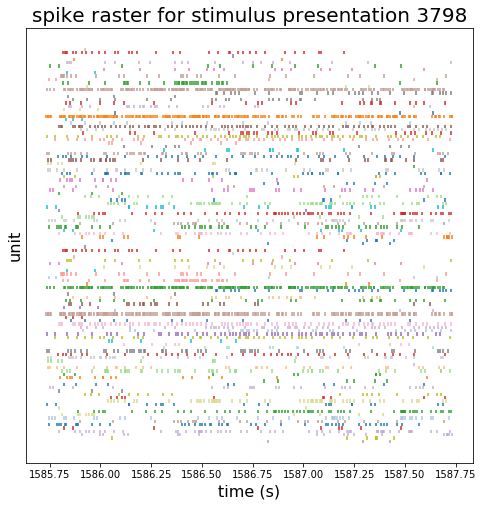

color                                                null
contrast                                              0.8
frame                                                null
orientation                                           180
phase                    [42471.86666667, 42471.86666667]
pos                                            [0.0, 0.0]
size                                       [250.0, 250.0]
spatial_frequency                                    0.04
start_time                                        1585.73
stimulus_block                                          2
stimulus_name                           drifting_gratings
stop_time                                         1587.74
temporal_frequency                                      2
x_position                                           null
y_position                                           null
duration                                          2.00168
stimulus_condition_id                                 246
Name: 3798, dt

In [21]:
first_drifting_grating_presentation_id = times['stimulus_presentation_id'].values[0]
plot_times = times[times['stimulus_presentation_id'] == first_drifting_grating_presentation_id]

fig = raster_plot(plot_times, title=f'spike raster for stimulus presentation {first_drifting_grating_presentation_id}')
plt.show()

# also print out this presentation
session.stimulus_presentations.loc[first_drifting_grating_presentation_id]

We can access summary spike statistics for stimulus conditions and unit

In [22]:
stats = session.conditionwise_spike_statistics(
    stimulus_presentation_ids=drifting_gratings_presentation_ids,
    unit_ids=high_snr_unit_ids
)

# display the parameters associated with each condition
stats = pd.merge(stats, session.stimulus_conditions, left_on="stimulus_condition_id", right_index=True)

stats.head()

,,spike_count,stimulus_presentation_count,spike_mean,spike_std,spike_sem,color,colorSpace,contrast,depth,flipHoriz,flipVert,frame,interpolate,mask,opacity,orientation,phase,pos,rgbPedestal,size,spatial_frequency,stimulus_name,temporal_frequency,tex,texRes,units,x_position,y_position,color_triplet
unit_id,stimulus_condition_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
951799336,246,13,15,0.866667,1.995232,0.515167,null,rgb,0.8,0,null,null,null,0,None,1,180,"[42471.86666667, 42471.86666667]","[0.0, 0.0]","[0.0, 0.0, 0.0]","[250.0, 250.0]",0.04,drifting_gratings,2,sin,256,deg,null,null,"[1.0, 1.0, 1.0]"
951800977,246,26,15,1.733333,2.737743,0.706882,null,rgb,0.8,0,null,null,null,0,None,1,180,"[42471.86666667, 42471.86666667]","[0.0, 0.0]","[0.0, 0.0, 0.0]","[250.0, 250.0]",0.04,drifting_gratings,2,sin,256,deg,null,null,"[1.0, 1.0, 1.0]"
951801127,246,103,15,6.866667,7.414914,1.914523,null,rgb,0.8,0,null,null,null,0,None,1,180,"[42471.86666667, 42471.86666667]","[0.0, 0.0]","[0.0, 0.0, 0.0]","[250.0, 250.0]",0.04,drifting_gratings,2,sin,256,deg,null,null,"[1.0, 1.0, 1.0]"
951801187,246,4,15,0.266667,0.593617,0.153271,null,rgb,0.8,0,null,null,null,0,None,1,180,"[42471.86666667, 42471.86666667]","[0.0, 0.0]","[0.0, 0.0, 0.0]","[250.0, 250.0]",0.04,drifting_gratings,2,sin,256,deg,null,null,"[1.0, 1.0, 1.0]"
951801462,246,83,15,5.533333,2.587516,0.668094,null,rgb,0.8,0,null,null,null,0,None,1,180,"[42471.86666667, 42471.86666667]","[0.0, 0.0]","[0.0, 0.0, 0.0]","[250.0, 250.0]",0.04,drifting_gratings,2,sin,256,deg,null,null,"[1.0, 1.0, 1.0]"


Using these data, we can ask for each unit: which stimulus condition evoked the most activity on average?

In [23]:
with_repeats = stats[stats["stimulus_presentation_count"] >= 5]

highest_mean_rate = lambda df: df.loc[df['spike_mean'].idxmax()]
max_rate_conditions = with_repeats.groupby('unit_id').apply(highest_mean_rate)
max_rate_conditions.head()

,spike_count,stimulus_presentation_count,spike_mean,spike_std,spike_sem,color,colorSpace,contrast,depth,flipHoriz,flipVert,frame,interpolate,mask,opacity,orientation,phase,pos,rgbPedestal,size,spatial_frequency,stimulus_name,temporal_frequency,tex,texRes,units,x_position,y_position,color_triplet
unit_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
951799336,81,15,5.400000,9.287472,2.398015,null,rgb,0.8,0.0,null,null,null,0.0,None,1.0,0,"[42471.86666667, 42471.86666667]","[0.0, 0.0]","[0.0, 0.0, 0.0]","[250.0, 250.0]",0.04,drifting_gratings,4,sin,256.0,deg,null,null,"[1.0, 1.0, 1.0]"
951800977,41,15,2.733333,2.840188,0.733333,null,rgb,0.8,0.0,null,null,null,0.0,None,1.0,45,"[42471.86666667, 42471.86666667]","[0.0, 0.0]","[0.0, 0.0, 0.0]","[250.0, 250.0]",0.04,drifting_gratings,1,sin,256.0,deg,null,null,"[1.0, 1.0, 1.0]"
951801127,209,15,13.933333,9.728211,2.511813,null,rgb,0.8,0.0,null,null,null,0.0,None,1.0,90,"[42471.86666667, 42471.86666667]","[0.0, 0.0]","[0.0, 0.0, 0.0]","[250.0, 250.0]",0.04,drifting_gratings,1,sin,256.0,deg,null,null,"[1.0, 1.0, 1.0]"
951801187,53,15,3.533333,5.902380,1.523988,null,rgb,0.8,0.0,null,null,null,0.0,None,1.0,270,"[42471.86666667, 42471.86666667]","[0.0, 0.0]","[0.0, 0.0, 0.0]","[250.0, 250.0]",0.04,drifting_gratings,4,sin,256.0,deg,null,null,"[1.0, 1.0, 1.0]"
951801462,136,15,9.066667,5.161211,1.332619,null,rgb,0.8,0.0,null,null,null,0.0,None,1.0,45,"[42471.86666667, 42471.86666667]","[0.0, 0.0]","[0.0, 0.0, 0.0]","[250.0, 250.0]",0.04,drifting_gratings,2,sin,256.0,deg,null,null,"[1.0, 1.0, 1.0]"


### Spike histograms

It is commonly useful to compare spike data from across units and stimulus presentations, all relative to the onset of a stimulus presentation. We can do this using the `presentationwise_spike_counts` method. 

In [24]:
# We're going to build an array of spike counts surrounding stimulus presentation onset
# To do that, we will need to specify some bins (in seconds, relative to stimulus onset)
time_bin_edges = np.linspace(-0.01, 0.4, 200)

# look at responses to the flash stimulus
flash_250_ms_stimulus_presentation_ids = session.stimulus_presentations[
    session.stimulus_presentations['stimulus_name'] == 'flashes'
].index.values

# and get a set of units with only decent snr
decent_snr_unit_ids = session.units[
    session.units['snr'] >= 1.5
].index.values

spike_counts_da = session.presentationwise_spike_counts(
    bin_edges=time_bin_edges,
    stimulus_presentation_ids=flash_250_ms_stimulus_presentation_ids,
    unit_ids=decent_snr_unit_ids
)
spike_counts_da

<xarray.DataArray 'spike_counts' (stimulus_presentation_id: 150, time_relative_to_stimulus_onset: 199, unit_id: 631)>
array([[[0, 1, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       ...,

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [1, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]]], dtype=uint16)
Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 3647 ... 3796
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 -0.00897 ... 0.399
  * unit_id                          (unit_id) int64 951814884 ... 951814312

This has returned a new (to this notebook) data structure, the `xarray.DataArray`. You can think of this as similar to a 3+D `pandas.DataFrame`, or as a `numpy.ndarray` with labeled axes and indices. See the [xarray documentation](http://xarray.pydata.org/en/stable/index.html) for more information. In the mean time, the salient features are:

- Dimensions : Each axis on each data variable is associated with a named dimension. This lets us see unambiguously what the axes of our array mean.
- Coordinates : Arrays of labels for each sample on each dimension.

xarray is nice because it forces code to be explicit about dimensions and coordinates, improving readability and avoiding bugs. However, you can always convert to numpy or pandas data structures as follows:
- to pandas: `spike_counts_ds.to_dataframe()` produces a multiindexed dataframe
- to numpy: `spike_counts_ds.values` gives you access to the underlying numpy array

We can now plot spike counts for a particular presentation:

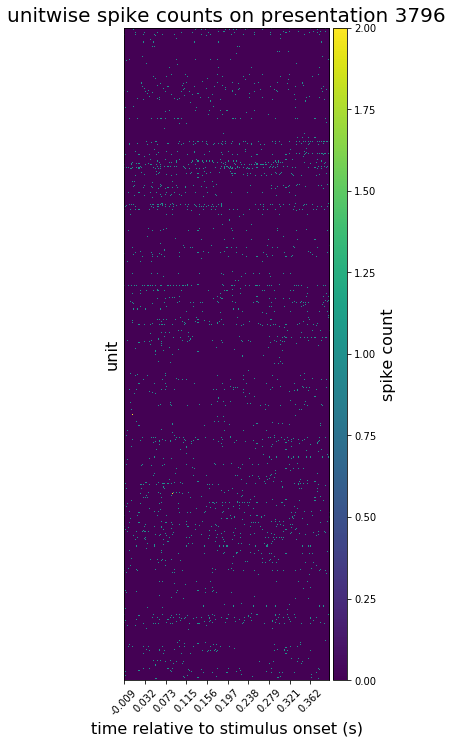

In [25]:
presentation_id = 3796 # chosen arbitrarily
plot_spike_counts(
    spike_counts_da.loc[{'stimulus_presentation_id': presentation_id}], 
    spike_counts_da['time_relative_to_stimulus_onset'],
    'spike count', 
    f'unitwise spike counts on presentation {presentation_id}'
)
plt.show()

We can also average across all presentations, adding a new data array to the dataset. Notice that this one no longer has a stimulus_presentation_id dimension, as we have collapsed it by averaging.

In [26]:
mean_spike_counts = spike_counts_da.mean(dim='stimulus_presentation_id')
mean_spike_counts

<xarray.DataArray 'spike_counts' (time_relative_to_stimulus_onset: 199, unit_id: 631)>
array([[0.026667, 0.1     , 0.08    , ..., 0.006667, 0.      , 0.006667],
       [0.026667, 0.066667, 0.046667, ..., 0.02    , 0.      , 0.      ],
       [0.02    , 0.113333, 0.033333, ..., 0.033333, 0.      , 0.      ],
       ...,
       [0.026667, 0.093333, 0.053333, ..., 0.006667, 0.      , 0.      ],
       [0.026667, 0.066667, 0.026667, ..., 0.006667, 0.02    , 0.      ],
       [0.026667, 0.12    , 0.02    , ..., 0.      , 0.      , 0.      ]])
Coordinates:
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 -0.00897 ... 0.399
  * unit_id                          (unit_id) int64 951814884 ... 951814312

... and plot the mean spike counts

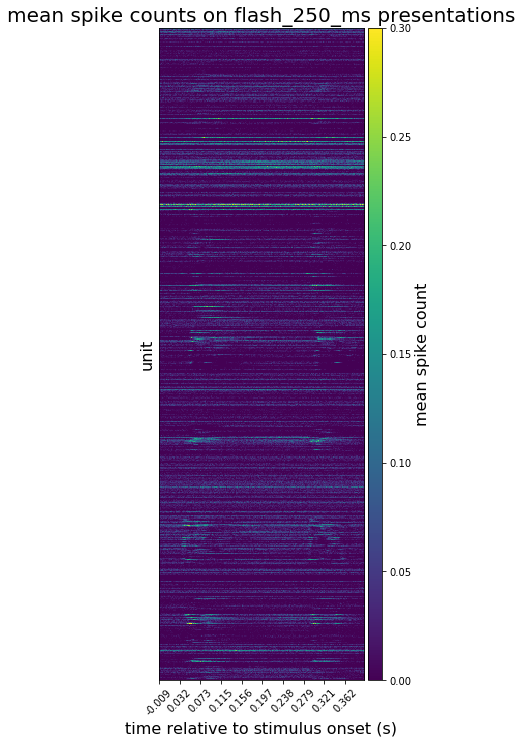

In [27]:
plot_spike_counts(
    mean_spike_counts, 
    mean_spike_counts['time_relative_to_stimulus_onset'],
    'mean spike count', 
    'mean spike counts on flash_250_ms presentations'
)
plt.show()

### Waveforms

We store precomputed mean waveforms for each unit in the `mean_waveforms` attribute on the `EcephysSession` object. This is a dictionary which maps unit ids to xarray [DataArrays](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html). These have `channel` and `time` (seconds, aligned to the detected event times) dimensions. The data values are in microvolts, as measured at the recording site.

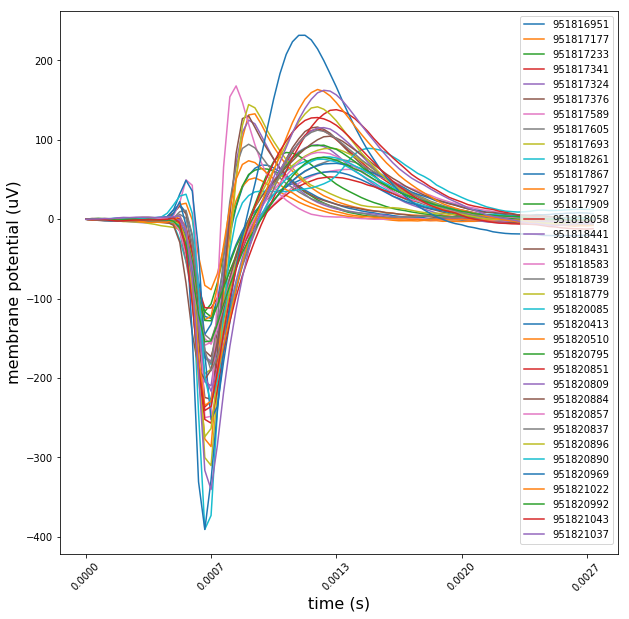

In [28]:
units_of_interest = high_snr_unit_ids[:35]

waveforms = {uid: session.mean_waveforms[uid] for uid in units_of_interest}
peak_channels = {uid: session.units.loc[uid, 'peak_channel_id'] for uid in units_of_interest}

# plot the mean waveform on each unit's peak channel/
plot_mean_waveforms(waveforms, units_of_interest, peak_channels)
plt.show()

Since neuropixels probes are densely populated with channels, spikes are typically detected on several channels. We can see this by plotting mean waveforms on channels surrounding a unit's peak channel:

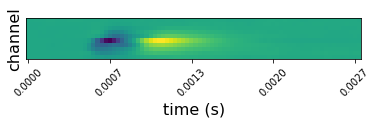

In [29]:
uid = units_of_interest[12]
unit_waveforms = waveforms[uid]
peak_channel = peak_channels[uid]
peak_channel_idx = np.where(unit_waveforms["channel_id"] == peak_channel)[0][0]

ch_min = max(peak_channel_idx - 10, 0)
ch_max = min(peak_channel_idx + 10, len(unit_waveforms["channel_id"]) - 1)
surrounding_channels = unit_waveforms["channel_id"][np.arange(ch_min, ch_max, 2)]

fig, ax = plt.subplots()
ax.imshow(unit_waveforms.loc[{"channel_id": surrounding_channels}])

ax.yaxis.set_major_locator(plt.NullLocator())
ax.set_ylabel("channel", fontsize=16)

ax.set_xticks(np.arange(0, len(unit_waveforms['time']), 20))
ax.set_xticklabels([f'{float(ii):1.4f}' for ii in unit_waveforms['time'][::20]], rotation=45)
ax.set_xlabel("time (s)", fontsize=16)

plt.show()

### Running speed

We can obtain the velocity at which the experimental subject ran as a function of time by accessing the `running_speed` attribute. This returns a pandas dataframe whose rows are intervals of time (defined by "start_time" and "end_time" columns), and whose "velocity" column contains mean running speeds within those intervals.

Here we'll plot the running speed trace for an arbitrary chunk of time.

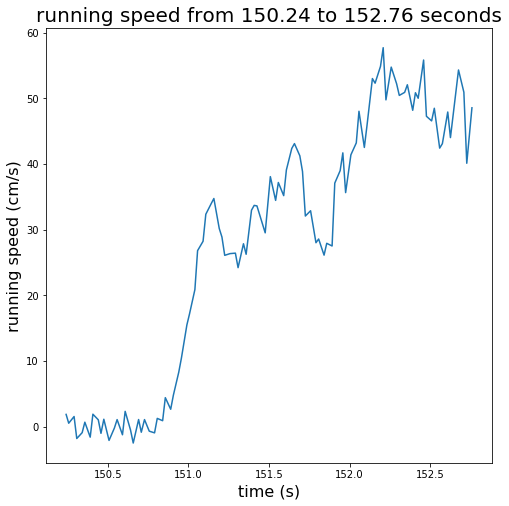

In [30]:
running_speed_midpoints = session.running_speed["start_time"] + \
    (session.running_speed["end_time"] - session.running_speed["start_time"]) / 2
plot_running_speed(
    running_speed_midpoints, 
    session.running_speed["velocity"], 
    start_index=5000,
    stop_index=5100
)
plt.show()

# Optogenetic stimulation

In [31]:
session.optogenetic_stimulation_epochs

,start_time,stop_time,condition,level,name,duration
id,,,,,,
0,9224.65339,9225.65339,half-period of a cosine wave,1.0,raised_cosine,1.000
1,9226.82361,9227.82361,half-period of a cosine wave,2.5,raised_cosine,1.000
2,9228.64353,9228.64853,a single square pulse,1.0,pulse,0.005
3,9230.65374,9230.66374,a single square pulse,4.0,pulse,0.010
4,9232.42375,9233.42375,2.5 ms pulses at 10 Hz,4.0,fast_pulses,1.000
...,...,...,...,...,...,...
175,9562.68831,9562.69331,a single square pulse,4.0,pulse,0.005
176,9564.75842,9564.76842,a single square pulse,1.0,pulse,0.010
177,9566.86855,9566.87855,a single square pulse,2.5,pulse,0.010


# Local Field Potential

We record local field potential on a subset of channels at 2500 Hz. Even subsampled and compressed, these data are quite large, so we store them seperately for each probe.

In [32]:
# list the probes recorded from in this session
session.probes.head()

,description,location,sampling_rate,lfp_sampling_rate,has_lfp_data
id,,,,,
760640083,probeA,,29999.949611,1249.997900,True
760640087,probeB,,29999.902541,1249.995939,True
760640090,probeC,,29999.905275,1249.996053,True
760640094,probeD,,29999.905275,1249.996053,True
760640097,probeE,,29999.985335,1249.999389,True


In [33]:
# load up the lfp from one of the probes. This returns an xarray dataarray

probe_id = session.probes.index.values[0]

lfp = session.get_lfp(probe_id)
print(lfp)

<xarray.DataArray 'LFP' (time: 12453025, channel: 87)>
array([[ 1.1895e-05,  2.7300e-05,  9.1650e-06, ...,  0.0000e+00,  2.7300e-06,
         3.9000e-07],
       [ 9.4185e-05,  8.9505e-05,  1.2285e-05, ...,  5.8500e-06,  5.8500e-06,
        -1.1505e-05],
       [ 6.0450e-05,  5.7915e-05,  1.4820e-05, ...,  0.0000e+00,  3.9000e-06,
        -1.4430e-05],
       ...,
       [ 1.0530e-05,  5.1285e-05,  8.3265e-05, ...,  0.0000e+00, -3.8025e-05,
        -2.1645e-05],
       [-1.3650e-06,  3.5685e-05,  5.4600e-05, ...,  0.0000e+00, -2.8470e-05,
        -2.4375e-05],
       [-1.0140e-05,  1.4625e-05,  3.5685e-05, ...,  2.7300e-06, -1.2675e-05,
        -9.5550e-06]], dtype=float32)
Coordinates:
  * time     (time) float64 3.774 3.775 3.776 ... 9.966e+03 9.966e+03 9.966e+03
  * channel  (channel) int64 850126378 850126386 ... 850127058 850127066


We can figure out where each LFP channel is located in the Brain

In [34]:
# now use a utility to associate intervals of /rows with structures
structure_acronyms, intervals = session.channel_structure_intervals(lfp["channel"])
interval_midpoints = [aa + (bb - aa) / 2 for aa, bb in zip(intervals[:-1], intervals[1:])]
print(structure_acronyms)
print(intervals)

['APN' 'DG' 'CA1' 'VISam' nan]
[ 0 27 35 51 74 87]


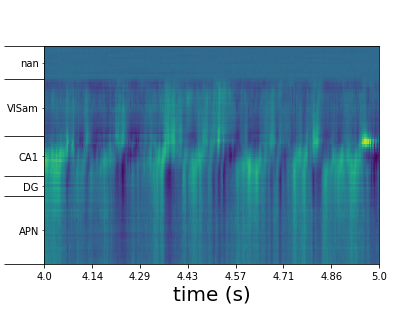

In [35]:
window = np.where(np.logical_and(lfp["time"] < 5.0, lfp["time"] >= 4.0))[0]

fig, ax = plt.subplots()
ax.pcolormesh(lfp[{"time": window}].T)

ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints, minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
plt.tick_params("y", which="major", labelleft=False, length=40)

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(window), num_time_labels)).astype(int) - 1
time_labels = [ f"{val:1.3}" for val in lfp["time"].values[window][time_label_indices]]
ax.set_xticks(time_label_indices + 0.5)
ax.set_xticklabels(time_labels)
ax.set_xlabel("time (s)", fontsize=20)

plt.show()

# Current source density

We precompute current source density for each probe.

In [36]:
csd = session.get_current_source_density(probe_id)
csd

<xarray.DataArray 'CSD' (virtual_channel_index: 384, time: 875)>
array([[-15929.946206,  -9764.690525,  -3800.635136, ...,  -3489.058296,
          4490.245594,  12683.655668],
       [  4926.68166 ,   1219.233312,  -2377.205218, ...,    395.49239 ,
         -2357.373563,  -5173.46221 ],
       [  8688.152839,   2851.906588,  -2829.810515, ...,  -1258.750536,
         -4710.397921,  -8222.475055],
       ...,
       [   795.133354,   -375.730633,  -1540.358552, ...,  -1500.276021,
         -1208.604462,   -970.134722],
       [ 39999.951669,  45568.256509,  51358.347642, ..., -42702.919159,
        -41541.349744, -40075.328791],
       [-43228.19425 , -44941.339   , -46869.879312, ...,  43678.786448,
         43072.463254,  42324.693548]])
Coordinates:
  * virtual_channel_index  (virtual_channel_index) int64 0 1 2 3 ... 381 382 383
  * time                   (time) float64 -0.1 -0.0996 -0.0992 ... 0.2492 0.2496
    vertical_position      (virtual_channel_index) uint64 0 10 20 ... 3820 

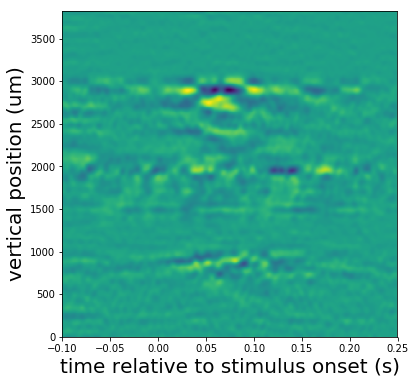

In [37]:
filtered_csd = gaussian_filter(csd.data, sigma=4)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pcolor(csd["time"], csd["vertical_position"], filtered_csd)

ax.set_xlabel("time relative to stimulus onset (s)", fontsize=20)
ax.set_ylabel("vertical position (um)", fontsize=20)

plt.show()

### Suggested excercises

If you would hands-on experience with the `EcephysSession` class, please consider working through some of these excercises.

- **tuning curves** : Pick a stimulus parameter, such as orientation on drifting gratings trials. Plot the mean and standard error of spike counts for each unit at each value of this parameter.
- **signal correlations** : Calculate unit-pairwise correlation coefficients on the tuning curves for a stimulus parameter of interest (`numpy.corrcoef` might be useful).
- **noise correlations** : Build for each unit a vector of spike counts across repeats of the same stimulus condition. Compute unit-unit correlation coefficients on these vectors.
- **cross-correlations** : Start with two spike trains. Call one of them "fixed" and the other "moving". Choose a set of time offsets and for each offset:
    1. apply the offset to the spike times in the moving train
    2. compute the correlation coefficient between the newly offset moving train and the fixed train.
    You should then be able to plot the obtained correlation coeffients as a function of the offset. 
- **unit clustering** : First, extract a set of unitwise features. You might draw these from the mean waveforms, for instance:
    - mean duration between waveform peak and trough (on the unit's peak channel)
    - the amplitude of the unit's trough
    
    or you might draw them from the unit's spike times, such as:
    - median inter-spike-interval
    
    or from metadata
    - CCF structure
    
    With your features in hand, attempt an unsupervised classification of the units. If this seems daunting, check out the [scikit-learn unsupervised learning documention](https://scikit-learn.org/stable/modules/clustering.html#clustering) for library code and examples.
- **population decoding** : Using an `EcephysSession` (and filtering to some stimuli and units of interest), build two aligned matrices:
    1. A matrix whose rows are stimulus presentations, columns are units, and values are spike counts.
    2. A matrix whose rows are stimulus presentations and whose columns are stimulus parameters.
    
    Using these matrices, train a classifier to predict stimulus conditions (sets of stimulus parameter values) from presentationwise population spike counts. See the [scikit-learn supervised learning tutorial](https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html) for a guide to supervised learning in Python.